# Generate the Dataset


In [1]:
import LLM
import json
import requests
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_core.tools import Tool
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.embeddings import SentenceTransformerEmbeddings
from langchain_text_splitters import SentenceTransformersTokenTextSplitter
from sentence_transformers import CrossEncoder
from pypdf import PdfReader
import os
from tqdm import tqdm
import numpy as np
from dotenv import load_dotenv, find_dotenv
import time
import csv
import pandas as pd

_ = load_dotenv(find_dotenv())  # read local .env file

/home/lance/miniconda3/envs/test/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup Local RAG DB


### Load Embedding Functions


In [2]:
ef = SentenceTransformerEmbeddings(model_name='BAAI/bge-large-en-v1.5', model_kwargs={'device':'cuda'})
reranker = CrossEncoder('BAAI/bge-reranker-large', device='cuda')

### Load Documents and Chunk


In [3]:
# meta_lookup = {
#     "Applied Empathy_ The New Language of Leade - Michael Ventura.pdf" : {
#         'author': "Michael Ventura",
#         'title': "Applied Empathy: The New Language of Leadership"
#     },
#     "Discursive Leadership_ In Conversation Wit - Gail T Fairhurst.pdf" : {
#         'author': "Gail T Fairhurst",
#         'title': "Discursive Leadership: In Conversation with Leadership Psychology"
#     },
#     "Leadership_ A Communication Perspective, S - Craig E. Johnson.pdf" : {
#         'author': "Craig E. Johnson",
#         'title': "Leadership: A Communication Perspective"
#     },
#     "Leadership_ Theory and Practice - Peter G. Northouse.pdf": {
#         'author': "Peter G. Northouse",
#         'title': "Leadership: Theory and Practice"
#     },
#     "Primal Leadership_ Unleashing the Power of - Daniel Goleman.pdf": {
#         'author': "Daniel Goleman, Richard E. Boyatzis, Annie McKee",
#         'title': "Primal Leadership: Unleashing the Power of Emotional Intelligence"
#     },
# }

# token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=512, model_name='BAAI/bge-large-en-v1.5')
# token_split_texts = []
# metadatas = []
# for fp in os.listdir('knowledge'):
#     reader = PdfReader('knowledge/' + fp)
#     pdf_text = [p.extract_text().strip() for p in reader.pages]
#     for page, text in enumerate(pdf_text):
#         if text:
#             split_texts = token_splitter.split_text(text)
#             token_split_texts += split_texts
#             meta = meta_lookup[fp].copy()
#             meta['page'] = page
#             metadatas += [meta] * len(split_texts)

# len(token_split_texts)

### Create the Local Vector DB

In [4]:
persist_path = os.path.join('storage', 'vectordb.parquet')

In [5]:
# vector_store = SKLearnVectorStore.from_texts(
#     texts=token_split_texts,
#     embedding=ef,
#     metadatas=metadatas,
#     persist_path=persist_path,
#     serializer='parquet',
# )

# vector_store.persist()

In [6]:
vector_store = SKLearnVectorStore(
    embedding=ef,
    persist_path=persist_path,
    serializer='parquet',
)

In [7]:
def get_local_search_results(query: str, vector_store, k: int = 10, n: int = 2, rerank: bool = True) -> list:
    """Searches the local vector DB for documents related to the provided query and returns them in a list

    Args:
        query (str): search query
        vector_store: the langchain vector database object which to search in
        k (int): number of documents to intially retrieve from the database (defaults to 10)
        n (int): number of documents to return from this function (defaults to 2)
        rerank (bool): whether to perform reranking on the retrieved documents (defaults to True)

    Returns:
        list: list of documents that are related to search query ordered by similarity
    """

    retrieved = vector_store.similarity_search(query, k=k)
    
    if rerank:
        pairs = [[query, doc.page_content] for doc in retrieved]
        scores = reranker.predict(pairs)
        top_n_idx = list(np.argsort(scores)[::-1][:n])
        top_n = [retrieved[i] for i in top_n_idx]
    else:
        top_n = retrieved[:n]

    return top_n

In [8]:
get_local_search_results('leadership communication tips', vector_store)

[Document(page_content='218 chapter seven rule 1 : be absent from as many group meetings as possible. don ’ t explain why you didn ’ t attend. rule 2 : contribute very little to the interaction. rule 3 : volunteer to be the secretary or the record keeper of your group ’ s discussion. this is an important role, but a recorder or secretary rarely ends up as the group ’ s leader. rule 4 : indicate that you are willing to do what you are told. while disinterest guarantees avoiding leadership responsibilities, subservience is not per - ceived as a leadership quality. rule 5 : come on [ too ] strong early in the group discussions. be extreme ; appear unwilling to compromise. rule 6 : try to assume the role of joker. make sure your jokes are off the topic and never let on that you are serious about anything. rule 7 : demonstrate your knowledge of everything, including your extensive vocab - ulary of big words and technical jargon. be a know - it - all and use words that others in the group wo

In [9]:
get_local_search_results('leadership communication tips', vector_store, rerank=False)

[Document(page_content='3 ) be careful how you view your fol - lower role, ( 4 ) know your audience, ( 5 ) don ’ t underestimate social influence, ( 6 ) performance counts, ( 7 ) be flexible, ( 8 ) focus attention on the “ we, ” not the “ me, ” and respect and reflect the group ’ s identity. application exercises 1. make a list of the qualities that you believe are important for effective leader - ship. compare your list with the communicative behaviors listed in table 2. 1, p. 42. do effective leaders seem to adopt one leadership communication stylemore than others? / ornament22johnson - hackman 7e. book page 69 wednesday, january 10, 2018 1 : 42 pm', metadata={'id': '33465323-cf74-46f7-9d3d-0c2f7aff539d', 'author': 'Craig E. Johnson', 'page': 87, 'title': 'Leadership: A Communication Perspective'}),
 Document(page_content='70 chapter two 2. in what types of situations do you believe each of the leadership communica - tion styles identified in this chapter would be most effective? lea

## Setup Web Search RAG


### Create the Web Vector DB

In [10]:
def get_web_search_results(query: str, search_k: int = 5, rag_k: int = 10, n: int = 2, rerank: bool = True) -> list:
    """Searches Google via Serper with the provided query and returns the results

    Args:
        query (str): search query
        seach_k (int): number of Google search results to return and store in web_store (defaults to 5)
        rag_k (int): number of documents to retrieve the web store (defaults to 10)
        n (int): number of documents to return from this function (defaults to 2)
        rerank (bool): whether to perform reranking on the retrieved documents (defaults to True)

    Returns:
        list: list of documents that are related to search query ordered by similarity
    """
    web_store = SKLearnVectorStore(
        embedding=ef,
        serializer='parquet',
    )
    url = 'https://google.serper.dev/search'
    headers = {
    'X-API-KEY': os.environ['SERPER_API_KEY'],
    'Content-Type': 'application/json'
    }
    payload = json.dumps({
        "q": query,
        "num": search_k
        })
    response = requests.request("POST", url, headers=headers, data=payload)
    search_results = json.loads(response.text)['organic']
    links = [x['link'] for x in search_results]
    metadatas = [{'title': x['title'], 'link': x['link']} for x in search_results]
    docs = WebBaseLoader(links).load()
    for i in range(len(docs)):
        docs[i].metadata = metadatas[i]
    texts = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=512, model_name='BAAI/bge-large-en-v1.5').split_documents(docs)
    web_store.add_documents(texts)

    retrieved = web_store.similarity_search(query, k=rag_k)
    
    if rerank:
        pairs = [[query, doc.page_content] for doc in retrieved]
        scores = reranker.predict(pairs)
        top_n_idx = list(np.argsort(scores)[::-1][:n])
        top_n = [retrieved[i] for i in top_n_idx]
    else:
        top_n = retrieved[:n]

    return top_n

In [11]:
get_web_search_results('leadership communication tips')

[Document(page_content='and great leader. whether you ’ re an executive, a manager or are simply looking to develop your leadership skills, there ’ s never been a better time to fine - tune your communication skills. in this article, we ’ ll explore why communication matters in leadership and how to level up your communication skills. why is communication important in leadership? according to a report from the economist intelligence unit on communication barriers in the workplace, it ’ s clear that communication has a big impact on work. out of the 403 corporate staff surveyed ( including executives, managers and junior employees ) : 44 % said communication barriers led to a failure to complete projects on time or at all. 33 % said poor communication causes low team morale. 25 % attributed a lack of communication to missed performance goals. 18 % said miscommunication led to the loss of a sale, a third of which is estimated to be over $ 100, 000 ( £82, 778 ). likewise, in a report by f

## Setup Feedback Refinement Pipeline


In [49]:
config = {
    "coach_system_prompt": "You are an expert leadership coach with lots of knowledge of leadership theory. You observe a role-play dialogue between a human trainee and an AI actor.\n\nThe human user is <user_name>, and the actor is <actor_name>.",
    "feedback_task": "Your specific job is the following:\nEvaluate the last communication from <user_name>. Provide feedback addressing <user_name> based on leadership theory and approaches that could help them improve their communication to become more effective. Only critique <user_name>'s communication and not <actor_name>'s.\n\nThe current dialogue is given between the triple backticks below.\n```{dialogue}```",
    "feedback_task_output_format": "The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nHere is the output schema:\n```\n{\"properties\": {\"item_title\": {\"title\": \"Item Title\", \"description\": \"title for detailed items to improve\", \"type\": \"string\", \"items\": {\"type\": \"string\"}}, \"item\": {\"title\": \"Item\", \"description\": \"detail of the item to improve\", \"type\": \"string\"}}, \"required\": [\"item_title\", \"item\"]}\n```"
}

rag_task = "Your specific job is to generate a query for the feedback item to search for the relevant information based on the feedback that you previously provided. The feedback items are given in a markdown list. This feedback is given between the XML <feedback></feedback> tags below.\n\n<feedback>\n{feedback}</feedback>\n\n"
rag_task_output_format = "The output should be formatted as a JSON instance that conforms to the following JSON schema {'query': ''}"

feedback_refinement_task = "Your specific job is to refine the feedback that you provided to the user based on the following information retrieved from leadership and communication books. Each query and documents relate to one of the feedback items. Please cite the reference if you use it. If the metadata has a link element create a hyperlink with the title using a markdown link format. The feedback is given in the XML tags <feedback></feedback> and the retrieved documents are given in the XML tags <retrieved></retrieved>.\n\n<feedback>\n{feedback}</feedback>\n<retrieved>\n{retrieved}</retrieved>\n\n"

CoachFeedback = LLM.OpenAIChatLLMAgent(store_responses=False, response_format={'type':'json_object'}, model='gpt-4-0125-preview', temperature=0.0)
CoachFeedback.system_prompt = config['coach_system_prompt'].format(**config)

CoachQuery = LLM.OpenAIChatLLMAgent(store_responses=False, response_format={'type':'json_object'}, model='gpt-3.5-turbo-0125', temperature=0.0)
CoachQuery.system_prompt = config['coach_system_prompt'].format(**config)

### Import Feedback Messages


In [13]:
with open('data/feedback_msgs.json') as f:
    feedback_msgs = json.load(f)
len(feedback_msgs)

35

In [14]:
# Get only the detailed feedback messages
detailed_feedback = []
for msg in feedback_msgs:
    for i in range(len(msg['content']['item_titles'])):
        detailed_feedback.append(f"{msg['content']['item_titles'][i]}: {msg['content']['items'][i]}\n".replace('<actor_name>','Taylor'))
len(detailed_feedback)

119

### Generate Refined Feedback for Each Detailed Feedback


In [50]:
def generate_query(feedback: str) -> str:
    msg = rag_task.format(feedback=feedback) + rag_task_output_format
    r = CoachFeedback.run(message=msg, temporary_message=True)
    try:
        return r
    except:
        raise ValueError

def refine_feedback_local(feedback: str, query: str) -> dict:
    """Refines the feedback based on the retrieved documents from the local vector database

    Args:
        feedback (str): the feedback item to refine
        query (str): the query to search for the relevant information

    Returns:
        dict: the refined feedback in form {'item_title': '...', 'item': '...'}
    """
    docs = get_local_search_results(query, vector_store)
    retrieved = ''
    retrieved += f'Query: {query}\n'
    for i, doc in enumerate(docs):
        retrieved += f"Doc{i+1}: {doc.page_content}\n"
        retrieved += f"Metadata{i+1}: {doc.metadata}\n"

    msg = feedback_refinement_task.format(feedback=feedback, retrieved=retrieved) + config['feedback_task_output_format']
    r = CoachFeedback.run(message=msg, temporary_message=True)
    return r

def refine_feedback_web(feedback: str, query: str):
    """Refines the feedback based on the retrieved documents from the web search

    Args:
        feedback (str): the feedback item to refine
        query (str): the query to search for the relevant information

    Returns:
        dict: the refined feedback in form {'item_title': '...', 'item': '...'}
    """
    docs = get_web_search_results(query)
    retrieved = ''
    retrieved += f'Query: {query}\n'
    for i, doc in enumerate(docs):
        retrieved += f"Doc{i+1}: {doc.page_content}\n"
        retrieved += f"Metadata{i+1}: {doc.metadata}\n"

    msg = feedback_refinement_task.format(feedback=feedback, retrieved=retrieved) + config['feedback_task_output_format']
    r = CoachFeedback.run(message=msg, temporary_message=True)
    return r

In [57]:
# Generate holder for the feedback
df = pd.DataFrame(columns=['feedback', 'query', 'query_t', 'feedback_local', 'feedback_local_time', 'feedback_local_c_tokens', 'feedback_local_p_tokens', 'feedback_web', 'feedback_web_time', 'feedback_web_c_tokens', 'feedback_web_p_tokens'])

In [68]:
# Iterate over each detailed feedback item and generate the other versions
for i, feedback in enumerate(tqdm(detailed_feedback, total=len(detailed_feedback))):
    # Copy the feedback item over
    feedback_none = feedback

    # Generate the query to search for documents
    start_time = time.time()
    try:
        query = json.loads(generate_query(feedback).choices[0].message.content)['query']
    except: 
        print(f'Error generating query for {i}: "{feedback}"')
        pass
    query_t = time.time() - start_time
    
    # Generate the local RAG refined feedback
    start_time = time.time()
    try:
        r = refine_feedback_local(feedback, query)
        feedback_local_t = time.time() - start_time
        # feedback_local = f"{r['item_title']}: {r['item']}"
        feedback_local = r
    except:
        print(f'Error refining local feedback for {i}: "{feedback}"')
        pass

    # Generate the web RAG refined feedback
    start_time = time.time()
    try:
        r = refine_feedback_web(feedback, query)
        feedback_web_t = time.time() - start_time
        # feedback_web = f"{r['item_title']}: {r['item']}"
        feedback_web = r
    except:
        print(f'Error refining web feedback for {i}: "{feedback}"')
        pass

    # Append the results to the dataframe
    results = pd.DataFrame({
        'feedback': feedback_none,
        'query': query,
        'query_t': query_t,
        'feedback_local': f'{json.loads(feedback_local.choices[0].message.content)['item_title']}: {json.loads(feedback_local.choices[0].message.content)['item']}',
        'feedback_local_time': feedback_local_t,
        'feedback_local_c_tokens': feedback_local.usage.completion_tokens,
        'feedback_local_p_tokens': feedback_local.usage.prompt_tokens,
        'feedback_web': f'{json.loads(feedback_web.choices[0].message.content)['item_title']}: {json.loads(feedback_web.choices[0].message.content)['item']}',
        'feedback_web_c_tokens': feedback_web.usage.completion_tokens,
        'feedback_web_p_tokens': feedback_web.usage.prompt_tokens,
        'feedback_web_time': feedback_web_t
        }, index=[0])
    df = pd.concat([df, results], ignore_index=True)

    # Store the results
    df.to_csv('data/feedback_results.csv', index=False)
    

  9%|▉         | 11/119 [05:03<42:36, 23.67s/it] 

Error refining web feedback for 10: "Empowering the Employee: Empower your employee by asking if there are any obstacles you can help remove or if there's anything they need to be more effective in their role. This not only shows that you care about their well-being but also encourages them to take ownership of their work and the challenges they face.
"


 26%|██▌       | 31/119 [14:41<38:43, 26.41s/it]

Error refining web feedback for 30: "Express Empathy: Given that you're about to ask Bobby to work extra hours, expressing empathy and acknowledging their efforts can go a long way in maintaining a positive relationship. Before making your request, consider saying something like, 'I realize you've been putting in a lot of effort, and I appreciate your hard work on this project.'
"


 30%|███       | 36/119 [16:55<34:54, 25.23s/it]

Error refining web feedback for 35: "Express Empathy: Starting the conversation by asking about the project's progress is a good approach, but it's important to also express understanding of the employee's workload and any challenges they may be facing. This can help in building a rapport and making the employee feel supported.
"


 37%|███▋      | 44/119 [20:39<30:20, 24.27s/it]

Error refining web feedback for 43: "Expressing Urgency: Given the critical nature of the deadline, it's important to communicate the urgency of the situation. You could say something like, 'I've noticed that we're behind on our milestones for the XYZ project, and it's crucial that we meet our upcoming deadline.' This sets the stage for the request for extra work and explains the reason behind it.
"


 73%|███████▎  | 87/119 [40:31<12:33, 23.56s/it]

Error refining web feedback for 86: "Empathy and Understanding: Empathy and Understanding: Given the sensitive nature of requesting extra work, especially over a weekend, demonstrating empathy is vital. Acknowledge the potential inconvenience and express appreciation for Taylor's efforts. This approach not only shows understanding but also helps in maintaining a positive relationship.
"


 76%|███████▋  | 91/119 [42:11<10:57, 23.49s/it]

Error refining web feedback for 90: "Motivate and Support: Motivate and Support: Highlighting the importance of Taylor's role in the project's success can be motivating. Additionally, offering support, whether it's resources, assistance from other team members, or flexibility in other areas, can demonstrate your commitment to their well-being and the project's success. For example, 'Your contribution is crucial to meeting our project deadline, and we're here to support you in any way needed to make this as manageable as possible for you.'
"


100%|██████████| 119/119 [56:55<00:00, 28.70s/it]


In [69]:
df

,feedback,query,query_t,feedback_local,feedback_local_time,feedback_local_c_tokens,feedback_local_p_tokens,feedback_web,feedback_web_time,feedback_web_c_tokens,feedback_web_p_tokens
0,Clarity and Respect: The communication could h...,How to communicate with employees in a profess...,3.455118,Enhancing Professionalism and Respect in Commu...,7.974918,189,2951,Enhancing Professional Communication and Respe...,12.577793,166,2961
1,Clarity and Respect: The communication could h...,How to communicate with employees in a profess...,1.926185,Enhancing Professionalism and Respect in Commu...,7.883796,192,2951,Enhancing Professional Communication and Respe...,13.009650,167,2958
2,Consideration and Context: It would be helpful...,How to effectively provide context and explain...,1.043000,Providing Context and Explaining Reasons Behin...,8.090895,192,2904,Consideration and Context in Leadership Commun...,17.359145,208,2955
3,Express Empathy: Starting the conversation wit...,how to express empathy in leadership communica...,1.673025,Expressing Empathy in Leadership Communication...,8.505779,165,2752,Enhancing Empathy in Leadership Communication:...,14.925500,211,2924
4,Provide Context: It's important to provide con...,How to effectively provide context and explain...,1.833553,Provide Context and Importance: When making a ...,30.844002,238,2919,Provide Context and Importance: When making a ...,17.712837,265,2951
...,...,...,...,...,...,...,...,...,...,...,...
115,Avoiding Assumptions: The statement made an as...,How to avoid making assumptions about an emplo...,1.716659,Enhancing Open Communication and Avoiding Assu...,8.157713,193,2771,Avoiding Assumptions and Engaging in Open Comm...,17.477256,187,3021
116,Avoid Potentially Judgmental Phrasing: The phr...,How to provide feedback without sounding judgm...,0.788049,Avoiding Judgmental Phrasing While Providing E...,6.127400,161,2816,Avoid Potentially Judgmental Phrasing: When pr...,18.879271,192,2993
117,Emphasize Collaborative Problem-Solving: While...,How to encourage collaborative problem-solving...,1.157396,Emphasize Collaborative Problem-Solving: To fo...,10.145669,233,2594,Emphasize Collaborative Problem-Solving: To en...,14.321613,197,2937
118,Express Support for Employee Needs: Expressing...,How to express support for employee needs and ...,3.194340,Enhancing Support for Employee Needs: To bette...,6.891391,154,2172,Enhancing Support for Employee Needs: To bette...,20.936828,165,2988


In [ ]:
# All web RAG errors
err_idx = [10,30,35,43,86,90]

## AI Model Trustworthiness Judge

In [121]:
import pandas as pd
import openai
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

In [297]:
JSON_DATASET_PATH = Path('llm_judge_results.json')

system_prompt = '''
You are a judge of leadership communication feedback trustworthiness. Below you will be provided with two pieces of feedback related to a hypothetical leadership communication utterance. Your task is to choose which of the two you feel is more **trustworthy**.

You can return one of the following values ['A','B','Tie']. Return your choice in the form of a JSON object with the key 'choice'. An example of this is {'choice': 'A'}.
'''

prompt_template = '''
Feedback A: {feedback_a}

Feedback B: {feedback_b}
'''

methods = ['none', 'local', 'web']

In [77]:
df = pd.read_csv('data/feedback_results.csv')
df = df[['feedback','feedback_local','feedback_web']].rename(columns={'feedback':'none','feedback_local':'local','feedback_web':'web'})
col_names = list(df.columns)
df.head()

,none,local,web
0,Clarity and Respect: The communication could h...,Enhancing Professionalism and Respect in Commu...,Enhancing Professional Communication and Respe...
1,Clarity and Respect: The communication could h...,Enhancing Professionalism and Respect in Commu...,Enhancing Professional Communication and Respe...
2,Consideration and Context: It would be helpful...,Providing Context and Explaining Reasons Behin...,Consideration and Context in Leadership Commun...
3,Express Empathy: Starting the conversation wit...,Expressing Empathy in Leadership Communication...,Enhancing Empathy in Leadership Communication:...
4,Provide Context: It's important to provide con...,Provide Context and Importance: When making a ...,Provide Context and Importance: When making a ...


In [206]:
def get_random_feedback():
    sample = {}
    x = df.sample(1, replace=True, axis=0)
    sample['index'] = x.index[0]
    x = x.sample(2, replace=False, axis=1)
    sample['a_method'] = x.columns[0]
    sample['b_method'] = x.columns[1]
    sample['a_feedback'] = x.values[0][0]
    sample['b_feedback'] = x.values[0][1]
    # print(f"Sampled: {sample['index']}")
    return sample

def vote(vote, sample):
    battle_outcome = {
        'sample_index': str(sample['index']),
        'sample_a_method': sample['a_method'],
        'sample_b_method': sample['b_method']
    }
    if vote == 'A':
        battle_outcome['winner'] = sample['a_method']
    elif vote == 'B':
        battle_outcome['winner'] = sample['b_method']
    elif vote == 'Tie':
        battle_outcome['winner'] = 'tie'
    # print(f"Voted: {sample['index']}")
    battle_results.append(battle_outcome)
    save_json()
    # print(battle_outcome)
    return

def save_json() -> None:
    with JSON_DATASET_PATH.open("w") as f:
        json.dump(battle_results, f)

def graph_battle_totals(results):
    temp = pd.DataFrame(results)
    total_battles = pd.concat([temp["sample_a_method"], temp["sample_b_method"]]).value_counts()
    temp = total_battles.reset_index()
    temp.columns = ["method", "total_battles"]
    sns.barplot(temp, x="method", y="total_battles", hue="method", order=methods)
    plt.title("Total Battles")

def graph_battle_h2h(results):
    temp = pd.DataFrame(results)
    temp["model_combination"] = temp.apply(
        lambda x: tuple(sorted([x["sample_a_method"], x["sample_b_method"]])), axis=1
    )

    # Count combinations
    combination_counts = temp["model_combination"].value_counts().reset_index()
    combination_counts.columns = ["model_combination", "count"]

    # Pivot the data for heatmap
    pivot_table = combination_counts.pivot_table(
        index="model_combination", columns="model_combination", values="count"
    )

    # The pivot_table needs to be adjusted to ensure it's in the correct format for a heatmap
    # First, we'll extract the unique models to create the correct matrix shape
    unique_models = sorted(set(temp["sample_a_method"]) | set(temp["sample_b_method"]))

    # Initialize a square dataframe with zeros
    heatmap_data = pd.DataFrame(0, index=unique_models, columns=unique_models)

    # Populate the heatmap data
    for _, row in combination_counts.iterrows():
        model_a, model_b = row["model_combination"]
        heatmap_data.loc[model_a, model_b] = row["count"]
        if model_a != model_b:  # Fill symmetric value if models are different
            heatmap_data.loc[model_b, model_a] = row["count"]

    sns.heatmap(heatmap_data, cmap="viridis", annot=True)
    plt.title("Method Battle Count")

### GPT-4 Turbo

In [ ]:
client = openai.OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [ ]:
battle_results = []

Total Battles: 68


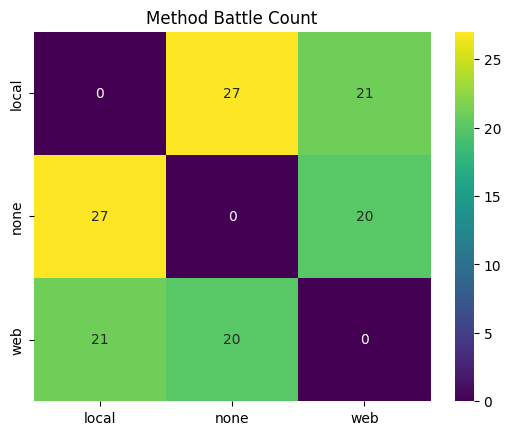

In [215]:
# Sample
sample = get_random_feedback()
msg = prompt_template.format(feedback_a=sample['a_feedback'], feedback_b=sample['b_feedback'])

response = client.chat.completions.create(
    model="gpt-4-0125-preview",
    response_format={ "type": "json_object" },
    messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": msg}
    ]
)

v = json.loads(response.choices[0].message.content)['choice']
vote(v, sample)
print(f'Total Battles: {len(battle_results)}')

graph_battle_h2h(battle_results)

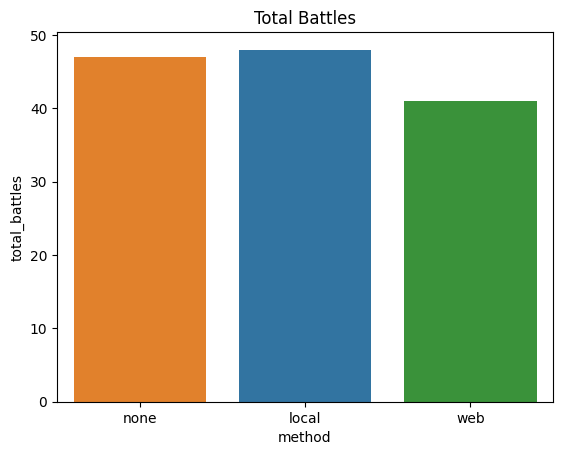

In [217]:
graph_battle_totals(battle_results)

### GPT-3.5 Turbo

In [ ]:
client = openai.OpenAI(api_key=os.environ['OPENAI_API_KEY'])

In [218]:
battle_results = []

Total Battles: 77


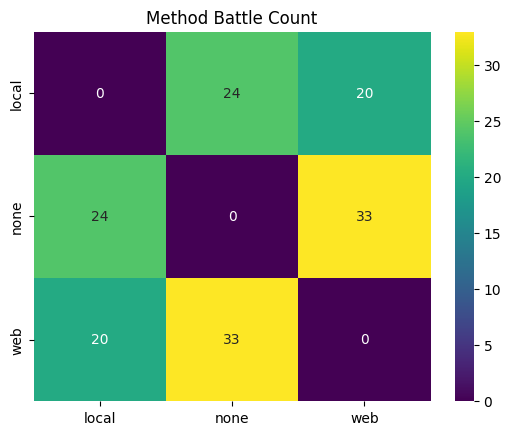

In [295]:
# Sample
sample = get_random_feedback()
msg = prompt_template.format(feedback_a=sample['a_feedback'], feedback_b=sample['b_feedback'])

response = client.chat.completions.create(
    model="gpt-3.5-turbo-0125",
    response_format={ "type": "json_object" },
    messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": msg}
    ]
)

v = json.loads(response.choices[0].message.content)['choice']
vote(v, sample)
print(f'Total Battles: {len(battle_results)}')

graph_battle_h2h(battle_results)

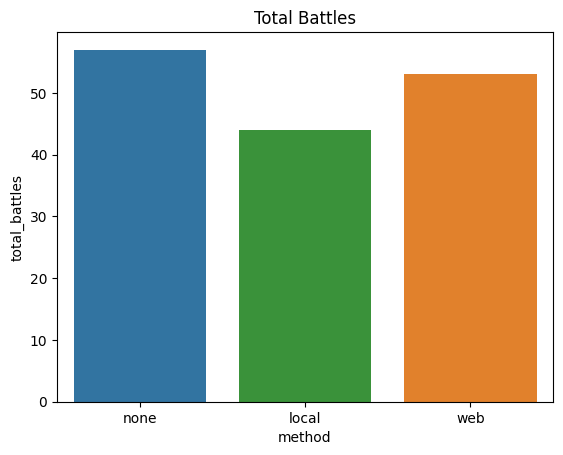

In [296]:
graph_battle_totals(battle_results)

### Llama2:7b-Chat

In [298]:
client = openai.OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

In [299]:
battle_results = []

Total Battles: 72


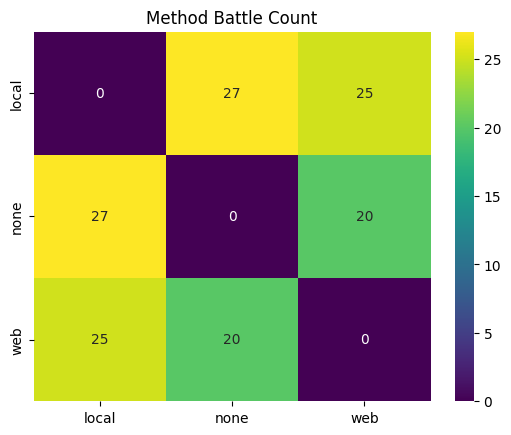

In [371]:
# Sample
sample = get_random_feedback()
msg = prompt_template.format(feedback_a=sample['a_feedback'], feedback_b=sample['b_feedback'])

response = client.chat.completions.create(
    model="llama2:chat",
    response_format={ "type": "json_object" },
    messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": msg}
    ]
)

v = json.loads(response.choices[0].message.content)['choice']
vote(v, sample)
print(f'Total Battles: {len(battle_results)}')

graph_battle_h2h(battle_results)

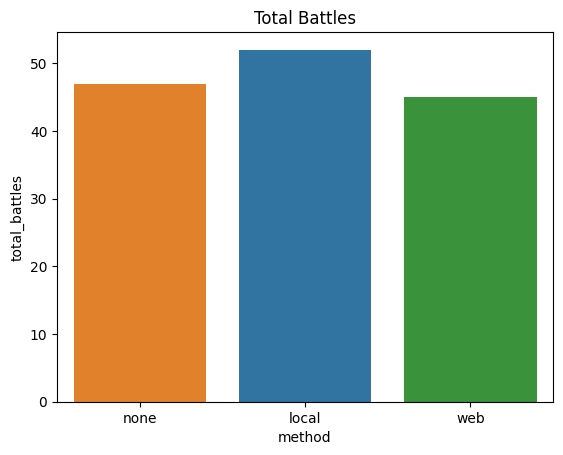

In [372]:
graph_battle_totals(battle_results)

**Notes:** Didn't run into issues with the JSON parsing. Fast

### Gemma:instruct

In [373]:
client = openai.OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

In [374]:
battle_results = []

Total Battles: 73


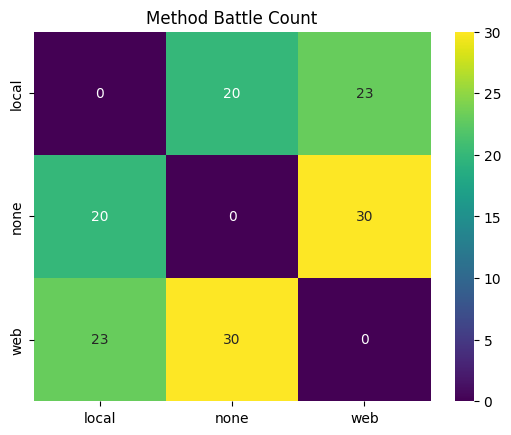

In [447]:
# Sample
sample = get_random_feedback()
msg = prompt_template.format(feedback_a=sample['a_feedback'], feedback_b=sample['b_feedback'])

response = client.chat.completions.create(
    model="gemma:instruct",
    response_format={ "type": "json_object" },
    messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": msg}
    ]
)

v = json.loads(response.choices[0].message.content)['choice']
vote(v, sample)
print(f'Total Battles: {len(battle_results)}')

graph_battle_h2h(battle_results)

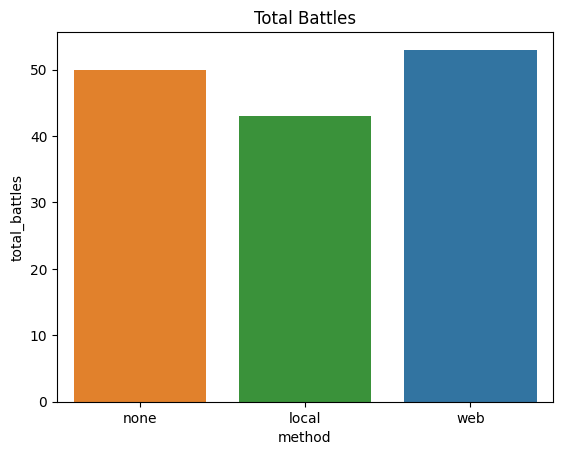

In [448]:
graph_battle_totals(battle_results)

**Notes:** Definitely not fast compared to Llama2. Feels about as fast as GPT-4 Turbo. No issues with JSON parsing.

### Mistral

In [450]:
client = openai.OpenAI(base_url='http://localhost:11434/v1', api_key='ollama')

In [451]:
battle_results = []

Total Battles: 60


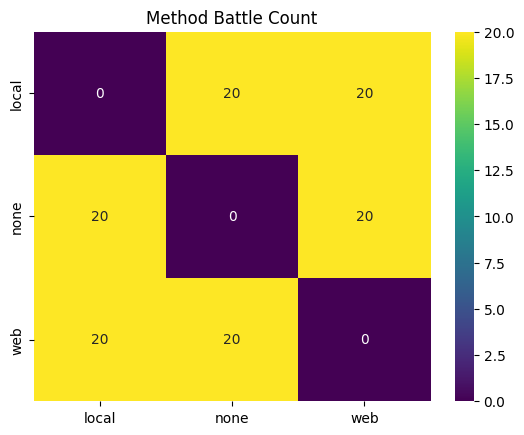

In [511]:
# Sample
sample = get_random_feedback()
msg = prompt_template.format(feedback_a=sample['a_feedback'], feedback_b=sample['b_feedback'])

response = client.chat.completions.create(
    model="mistral",
    response_format={ "type": "json_object" },
    messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": msg}
    ]
)

v = json.loads(response.choices[0].message.content)['choice']
vote(v, sample)
print(f'Total Battles: {len(battle_results)}')

graph_battle_h2h(battle_results)

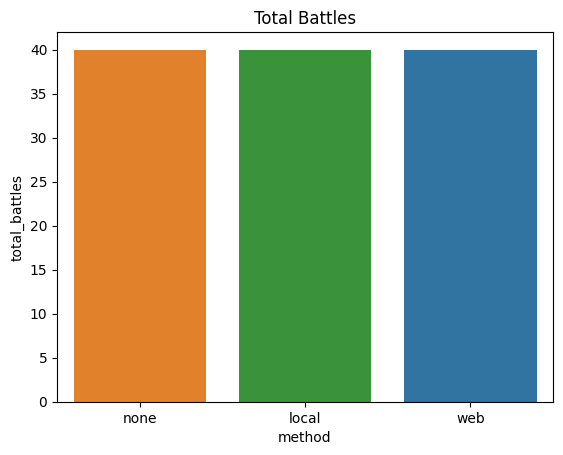

In [512]:
graph_battle_totals(battle_results)

**Notes:** Decently fast. No issues with JSON parsing